<a href="https://colab.research.google.com/github/vjacobsen/Inventory_Simulation/blob/main/Inventory_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Simulation

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import norm
from scipy import stats

## Optional: Enable data table display
%load_ext google.colab.data_table

## Functions

The reorder point is calculated as the sum of the average demand during lead time, plus the safety stock, plus the undershoot buffer. The undershoot happens when the order is generated below the reorder point, a very common and natural occurence when demand is not fixed to 1 or 0. To account for this, an additional parameter is added to the lead time demand and deviation.

"For any two independent random variables X and Y, if S = X + Y, the variance of S is SD^2= (X+Y)^2 . To find the standard deviation, take the square root of the variance formula: SD = sqrt(SDX^2 + SDY^2)."
[Source](https://fiveable.me/ap-stats/unit-4/combining-random-variables/study-guide/4a4RK1Yx83jckDNdzaX6)

In [2]:
def run_simulation(demand_input, use_emp_reorder_pt=False):  

  global stock,inventory_data,safety_stock,lt_demand_variability,mean_lt_demand,\
          demand,reorder_point,open_orders,lost_sales,on_order_qty,period,closed_orders,\
          delivery_this_period

  # Inventory replenishment parameters, undershoot correction
  lt_demand_variability,mean_lt_demand = lt_stdev_func(1000)  
  
  # Undershoot as a function of mean period's demand and demand 
  # The undershoot standard deviation is an approximation 
  mean_undershoot = np.mean(demand_input)/2
  stdev_undershoot = np.mean(demand_input)/4 + np.std(demand_input)/3
  
  mean_lt_demand = mean_lt_demand + np.mean(demand_input/2) # Corrected for undershoot

  # Total lead time demand variability with undershoot stdev added, corrected for undershoot
  lt_demand_variability = (lt_demand_variability**2 + stdev_undershoot**2)**0.5 
  
  # For the safety stock, we assume the total lead time demand distribution is normal
  safety_stock = round(stats.norm.ppf(desired_service_level) * lt_demand_variability,0)
  
  # The empirical reorder point is calculated from sampled data of the simulation
  if use_emp_reorder_pt: 
    safety_stock_empirical = round(stats.norm.ppf(desired_service_level) * np.std(empirical_lt_demand_df),0)[0]
    reorder_point = np.mean(empirical_lt_demand_df)[0] + safety_stock_empirical
  else:
    reorder_point = round(mean_lt_demand + safety_stock,0) 

  # Initialize variables
  lost_sales = 0
  open_orders = {}
  closed_orders = {}
  next_order_id = 0
  on_order_qty = 0
  inventory_data = []

  # Initial inventory as function of demand
  initial_inventory = reorder_point + actual_order_qty/2
  stock = initial_inventory
  stockouts = 0

  # Simulate periods 
  for period in np.arange(1,periods+1):
    
    stock_start = stock
    demand = round(demand_input[period-1]) 

    ## Subtract sold units from inventory - demand before order arrives 
    if stock == 0: # Currently out of stock awaiting replenishment
      lost_sales = demand
      stock = 0
      stockouts = 0
      inventory_out_of_stock = 1
    
    elif demand > stock: # Stockout event
      lost_sales = abs(demand - stock)
      stock = 0
      stockouts = 1 # Period where stockout occured
      percent_filled = stock/demand 
      inventory_out_of_stock = 1
    
    else: # No stockout, inventory still positve
      stock = stock - demand
      lost_sales = 0
      stockouts = 0
      inventory_out_of_stock = 0

    ## Create replnishment order?
    if stock + on_order_qty <= reorder_point: 
      order_count = 1
      oq = actual_order_qty
      order_lead_time = round(lead_time)
      delivery_period = period + order_lead_time
      
      order_details = {'delivery_period':delivery_period,
                        'order_qty':oq, 
                        'ordered_period':period
                       }
                       
      on_order_qty = on_order_qty + oq # Update on-order qty
      open_orders[period] = order_details # Add order to dictionary

    else:
      order_count = 0

    ## Replenish inventory
    delete_orders = [] # Will be used later to pop orders from open order dict
    
    for order_id in open_orders: 
      if open_orders[order_id]['delivery_period'] == period:
        delivery_qty = open_orders[order_id]['order_qty']
        stock = stock + delivery_qty # Add order qty to stock
        closed_orders[order_id] = open_orders[order_id] # Move to closed orders
        on_order_qty = on_order_qty - delivery_qty
        delete_orders.append(order_id)
 
    for order_id in delete_orders: 
      open_orders.pop(order_id) # Remove delivered orders from open orders dict
      
    # Metrics list
    inventory_data.append([period, 
                           demand, 
                           stock, 
                           on_order_qty, 
                           lost_sales,
                           order_count,
                           stockouts,
                           inventory_out_of_stock,
                           stock_start          
                           ]
                          ) 
  

  # Metrics data frame  
  inventory_data = pd.DataFrame(inventory_data,
                                columns=['period',
                                         'demand',
                                         'stock_on_hand',
                                         'stock_on_order',
                                         'lost_sales',
                                         'order_count',
                                         'stockouts',
                                         'inventory_out_of_stock',
                                         'stock_start'
                                         ]
                                ) 
  

# Calculate standard deviation of sum of demand sampled in groups of n periods, where n is the lead time duration 
def lt_stdev_func(samples):

  global stdev_list,lt_demand_list
  
  i=0
  lt_demand_list = []
  demand_list = list(demand_array)
  
  # Calculate lead time demand variability - bootstrap the demand periods
  while i < samples: # Calculate multiple samples of potential lead time demand
    i = i+1
    sample_data = random.sample(demand_list,lead_time)
    lt_demand = sum(sample_data)
    lt_demand_list.append(lt_demand)
    
  return np.std(lt_demand_list, ddof=1),np.mean(lt_demand_list)


# Metrics calculation after simulation run is finished
def compute_metrics():

    global zero_on_hand_periods_pcnt, fulfilled_demand, total_demand, average_demand,\
            total_orders, cycles_without_stockout
            
    inventory_cycles = len(closed_orders) 
    cycles_without_stockout = 1 - round(inventory_data['stockouts'].sum() / inventory_cycles,3)   
    total_demand = round(inventory_data['demand'].sum())
    average_demand = round(inventory_data['demand'].mean())

**Service Level** is the probability that the amount of inventory on hand during the lead time is sufficient to meet expected demand – that is, the probability that a stockout will not occur.

## Input parameters

In [3]:
# Input parameters
item_cost = 5
order_cost = 2
holding_cost = .05 # Percent of item cost

periods = 365 # number of periods to simulate
period_freq = 365 # number of periods in 1 year
lead_time = 15 # periods
desired_service_level = 0.9

# Generate random demand or provide list. UOM: Per period
mean_demand = 300 
stdev_demand = 40

# Calculated stock replenishment tresholds
annual_demand = mean_demand * period_freq
actual_order_qty = 15000

## Test simulation once
Validate parameters are working correctly

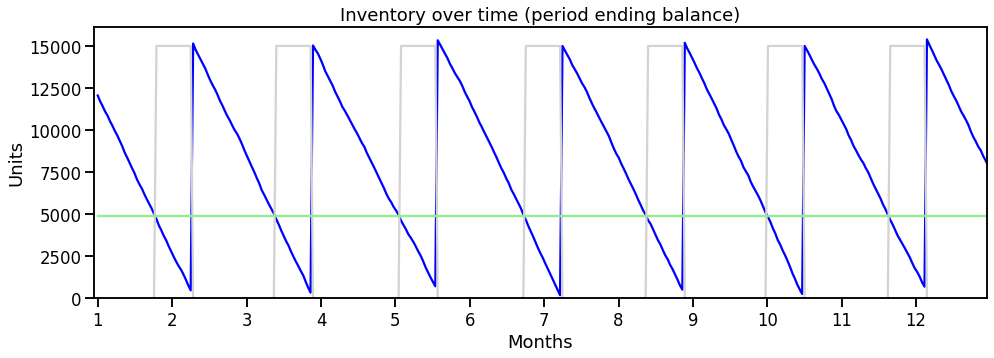


 Actual order qty 15000 
 safety stock 219.0 
 lead time demand  4656.703270797564 
 reorder point  4876.0 
 desired service level 0.9 



Stockout envents -  2
Cycles without stockout -  71.0 %
_______________________________________________________________________ 

       period  demand  ...  inventory_out_of_stock  stock_start
count     365     365  ...                     365          365
mean      183     300  ...                       0         7947
std       105      38  ...                       0         4296
min         1     206  ...                       0          185
25%        92     274  ...                       0         4309
50%       183     299  ...                       0         8167
75%       274     326  ...                       0        11570
max       365     409  ...                       1        15386

[8 rows x 9 columns]


In [4]:
# Generate random demand
demand_array = abs(np.random.normal(mean_demand,stdev_demand,periods))

run_simulation(demand_array,)

compute_metrics()

# Plot
df = inventory_data
sns.set_context('talk')

plt.figure(figsize=(16,5))
plt.title('Inventory over time (period ending balance)')

sns.lineplot(x=df['period'],y=df['stock_on_hand'],color='blue')
sns.lineplot(x=df['period'],y=df['stock_on_order'], color='lightgrey')
sns.lineplot(x=df['period'],y=reorder_point, color='lightgreen')
sns.barplot(x=df['period'],y=df['lost_sales'], color='red')

plt.ylabel('Units')
plt.xlabel('Months')
plt.xticks(np.arange(1, max(df['period']), period_freq/12))
plt.show()

# Print report
print('\n', 
      'Actual order qty', actual_order_qty, '\n',
      'safety stock', safety_stock, '\n',
      'lead time demand ', mean_lt_demand,'\n',
      'reorder point ', reorder_point ,'\n',
      'desired service level', desired_service_level, '\n'
      )
print('\n')

print( "Stockout envents - ", inventory_data['stockouts'].sum())
print("Cycles without stockout - ", 100*round(cycles_without_stockout,2),"%")

print("_______________________________________________________________________ \n")

print(inventory_data.describe().astype(int))

## Visualizing the undershoot

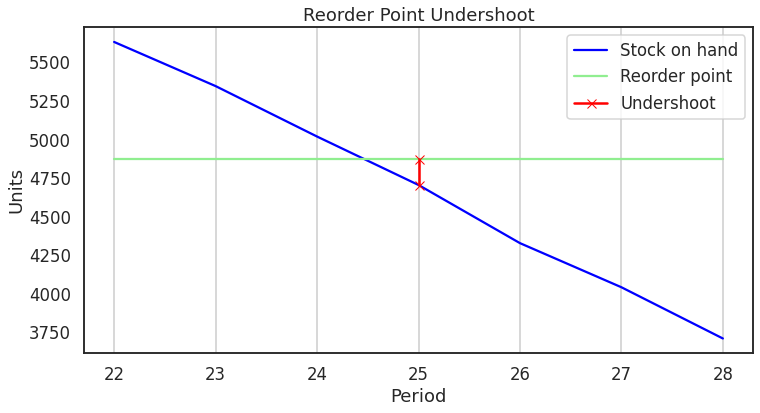

Calculated reorder point is 4876 units.
However, the replenishment order is only generated at the end of period 25, when stock is already at 4705 units


In [5]:
# Get second order period (it can be any period)
order_index = inventory_data[inventory_data['order_count']==1].index[1] 

# Subset inventory data to +- 3 periods around order to make viewing undershoot easier
df = inventory_data.loc[order_index-3:order_index+3]
undershoot = reorder_point - df.loc[order_index]['stock_on_hand']

# Plot
sns.set_context('talk')
sns.set_style('white')

plt.figure(figsize=(12,6))
plt.title('Reorder Point Undershoot')

# Inventory and reorder point
sns.lineplot(x=df['period'],y=df['stock_on_hand'],color='blue')
sns.lineplot(x=df['period'],y=reorder_point, color='lightgreen')

# Plot undershoot line
bottom, top = plt.ylim() # get y axis limts, used as reference to plot vertical line
y_min_undershoot = (reorder_point-undershoot - bottom)/(top-bottom)
y_max_undershoot = (reorder_point - bottom)/(top-bottom)
plt.axvline(order_index+1,
            y_min_undershoot,
            y_max_undershoot,
            color='r',
            linewidth=2.5,
            marker='x') 

plt.ylabel('Units')
plt.xlabel('Period')
plt.legend(('Stock on hand','Reorder point','Undershoot'))
plt.gca().xaxis.grid(True) # vertical lines
plt.show()

print("Calculated reorder point is {} units.\nHowever, the replenishment order is only generated at the end of period {}, \
when stock is already at {} units".format(round(reorder_point),order_index+1,round(reorder_point-undershoot)))

As can be seen in the plot above, by the time a replenishment order is generated, the inventory position is well below the reorder point. As such, this gap between calculated reorder point and actual order point must be taken into consideration in inventory replenishment parameter calcualtions. Statistically, the undershoot calculation is quite complex so an approximation of the lead time demand will be obtatined from actual simulation results

## Lead time demand distribution
We'll estimate the empirical safety stock and reorder point required for each desired service level through random sampling of observed total lead time demand values. Given as: 

### Random sampling of inventory levels

In [6]:
# Function to run inventory simulation for n number of times
def batch_simulation(service_level=0.95,runs=400,emp_order_pt=False,reorder=0):
  
  global desired_service_level
  
  # Initialize variables
  desired_service_level = service_level
  simulation_number = 0
  metrics = []
  undershoot_list = []
  simulation_runs = runs

  while simulation_number < simulation_runs:  
    
    # Generate random demand
    demand_array = abs(np.random.normal(mean_demand,stdev_demand,periods))
  
    run_simulation(demand_array,use_emp_reorder_pt=emp_order_pt)
    
    compute_metrics()
    
    # Calculate undershoot its mean/std statistics
    orders_df = inventory_data[inventory_data['order_count']==1].copy()
    orders_df['undershoot'] = reorder_point - orders_df['stock_on_hand']
    
    mean_undershoot = orders_df['undershoot'].mean()
    std_undershoot = orders_df['undershoot'].std()
    
    undershoot_list.append(list(orders_df['undershoot']))
    
    # Result metrics list
    metrics.append([
                    total_demand,
                    average_demand,
                    cycles_without_stockout,
                    mean_undershoot,
                    std_undershoot
                    ]
                  )
    
    simulation_number = simulation_number + 1

  results = pd.DataFrame(metrics,columns=[
                                'mean_total_demand',
                                'mean_average_demand',
                                'cycles_without_stockout',
                                'mean_undershoot',
                                'std_undershoot'
                                ])
  return results

Run simulation for calculated reorder point at any given desired service level. The batch simulation data will later be used to estimate the undershoot's distribution and total lead time demand.

In [7]:
results = batch_simulation(service_level=.95,runs=300)

print("Mean Service Level of Simulation Runs")
print(round(results['cycles_without_stockout'].mean(),3))

print(results.mean_undershoot.mean())
print(results.std_undershoot.mean())

Mean Service Level of Simulation Runs
0.952
151.8909523809524
89.86257116570756


### Calculate undershoot distribtuon

We'll take 5000 random samples out of the **undershoots** (observed across 300 runs of inventory simulation) added to a random observation of the total **post-order lead time demand** from the previously generated lead time demand list.

In [8]:
# List all undershoots across simulation runs
undershoots = pd.DataFrame(undershoot_list).unstack().dropna()

# Sample n number of lead time demands with undershoot demand
i=0 
total_lead_time_demand = []
while i<5000:

  i = i+1
  lt_demand_sample = lt_demand_list[np.random.randint(0,len(lt_demand_list))]
  undershoot_sample = list(undershoots)[np.random.randint(0,len(undershoots))]
  
  total_lead_time_demand.append(undershoot_sample+lt_demand_sample)

# The total lead time demand = demand after order generation + undershoot demand
empirical_lt_demand_df = pd.DataFrame(total_lead_time_demand)

#### Plot lead time demand histograms

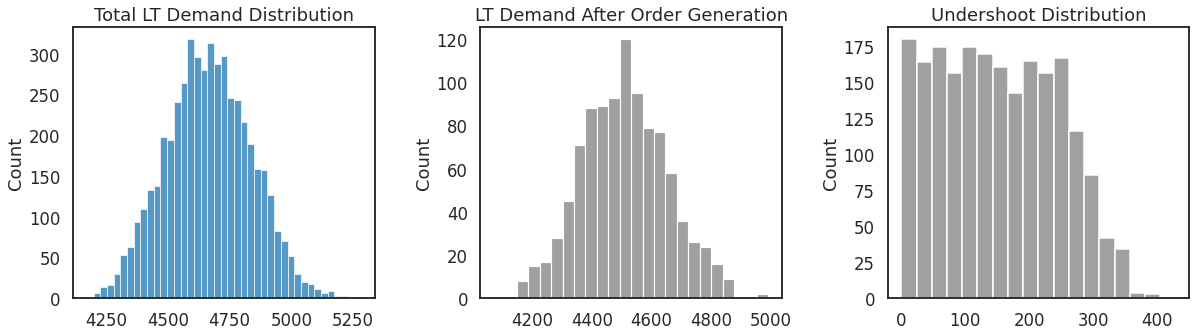

In [9]:
# Plot total lead time distribution
sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace = .35)

plt.subplot(1, 3, 1)
plt.title('Total LT Demand Distribution')
sns.histplot(total_lead_time_demand)

plt.subplot(1, 3, 2)
plt.title('LT Demand After Order Generation')
sns.histplot(lt_demand_list,color='grey')

plt.subplot(1, 3, 3)
plt.title('Undershoot Distribution')
sns.histplot(pd.DataFrame(undershoot_list).unstack(),color='grey')


plt.show()

Total lead time demand is equal to *Undershoot +  Lead Time Demand (after order generation)*. The undershoot demand distribution is not normal. For this project, it is assumed the total demand after reorder point (lead time) is normally distributed. For higher lead times, the total lead time demand will be less affected by the undershoot demand distribution, since it's mean value is very close to half the mean of the period's demand.

### Empirical Reorder Points

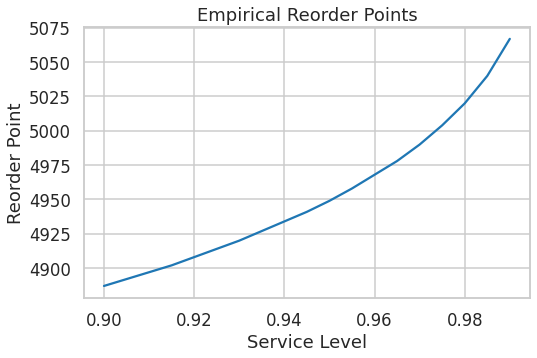

In [10]:
# Calculate quantiles for each service level, will be used to set reorder point
service_levels_dict = {}

theoretical_service_levels = np.arange(0.90,0.995,0.005).round(3)

for sl in theoretical_service_levels:
  safety_stock_empirical = round(stats.norm.ppf(sl) * np.std(empirical_lt_demand_df),0)[0]
  service_levels_dict[sl] = np.mean(empirical_lt_demand_df)[0] + safety_stock_empirical

# Plot
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
plt.title('Empirical Reorder Points')
data = pd.DataFrame(service_levels_dict.values(),index=service_levels_dict.keys())
sns.lineplot(x=data.index,y=data[0])
plt.ylabel('Reorder Point')
plt.xlabel('Service Level')
plt.show()

## Simulation accuracy

To test simulation accuracy, we'll run batch simulations for each desired service level's reorder points, calculated from both statistical and empirical lead time demand distributions, and compare to the actual mean service level observed across the simulations ran.

### Using empirical reorder point: desired vs actual service levels

In [11]:
# Create list of service levels to be tested and run 400 simulations (default function value) for each
observed_service_levels = [] 

for sl in theoretical_service_levels:
  results = batch_simulation(sl,emp_order_pt=True).mean().round(3)
  observed_service_levels.append(results['cycles_without_stockout'])
  print(sl," - ",results['cycles_without_stockout'])

# Calculate correlation coefficient
corr_coef = np.corrcoef(x=theoretical_service_levels,
                        y=observed_service_levels
                        )[0][1].round(3)

print("\n Correlation coefficient: {} ".format(corr_coef))

# Accuracy
error_percent_points = np.abs(observed_service_levels - theoretical_service_levels).mean()*100

print("\n Absolute Service Level Error (pp): {}".format(error_percent_points.round(2)))

0.9  -  0.912
0.905  -  0.902
0.91  -  0.915
0.915  -  0.919
0.92  -  0.927
0.925  -  0.924
0.93  -  0.924
0.935  -  0.926
0.94  -  0.939
0.945  -  0.942
0.95  -  0.953
0.955  -  0.957
0.96  -  0.963
0.965  -  0.965
0.97  -  0.97
0.975  -  0.972
0.98  -  0.98
0.985  -  0.983
0.99  -  0.989

 Correlation coefficient: 0.986 

 Absolute Service Level Error (pp): 0.34


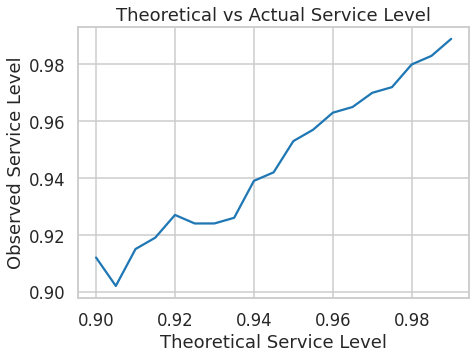

In [12]:
# Plot
sns.set_style('whitegrid')
plt.figure(figsize=(7,5))
plt.title('Theoretical vs Actual Service Level')
sns.lineplot(x=theoretical_service_levels,y=observed_service_levels)
plt.ylabel("Observed Service Level")
plt.xlabel("Theoretical Service Level")
plt.show()

### Calculated statistical reorder point: desired vs actual service levels

In [13]:
# Create list of service levels to be tested and run 400 simulations (default function value) for each
observed_service_levels = [] 

for sl in theoretical_service_levels:
  results = batch_simulation(sl,runs=300).mean().round(3)
  observed_service_levels.append(results['cycles_without_stockout']) 
  print(sl," - ",results['cycles_without_stockout'])

# Calculate correlation coefficient
corr_coef = np.corrcoef(x=theoretical_service_levels,
                        y=observed_service_levels
                        )[0][1].round(3)

print("\n Correlation coefficient: {} ".format(corr_coef))

# Accuracy
error_percent_points = np.abs(observed_service_levels - theoretical_service_levels).mean()*100

print("\n Absolute Service Level Error (pp): {}".format(error_percent_points.round(2)))

0.9  -  0.882
0.905  -  0.906
0.91  -  0.904
0.915  -  0.914
0.92  -  0.918
0.925  -  0.918
0.93  -  0.918
0.935  -  0.919
0.94  -  0.93
0.945  -  0.936
0.95  -  0.949
0.955  -  0.956
0.96  -  0.954
0.965  -  0.957
0.97  -  0.971
0.975  -  0.97
0.98  -  0.974
0.985  -  0.987
0.99  -  0.986

 Correlation coefficient: 0.984 

 Absolute Service Level Error (pp): 0.61


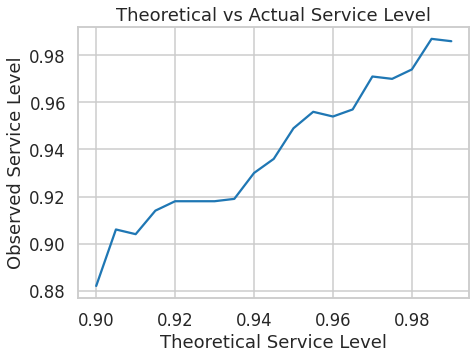

In [14]:
# Plot
sns.set_style('whitegrid')
plt.figure(figsize=(7,5))
plt.title('Theoretical vs Actual Service Level')
sns.lineplot(x=theoretical_service_levels,y=observed_service_levels)
plt.ylabel("Observed Service Level")
plt.xlabel("Theoretical Service Level")
plt.show()

Overall actual vs desired service level results for the input parameters specified in the beggining of this notebook are very similar. The statistical approximation of the undershoot with lead time demand after order generation resulted in slightly higher absolute error at 0.61 percent points, compared to 0.34 when using random sampling of lead time demand with undershoot from actual simulation results.